# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
}
check_packages(d)

[OK] Your Python version is 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:35:11) 
[Clang 11.1.0 ]
[OK] torch 1.10.1


Chapter 15: Modeling Sequential Data Using Recurrent Neural Networks (part 3/3)
========



**Outline**

- Implementing RNNs for sequence modeling in PyTorch
  - [Project two -- character-level language modeling in PyTorch](#Project-two----character-level-language-modeling-in-PyTorch)
    - [Preprocessing the dataset](#Preprocessing-the-dataset)
    - [Evaluation phase -- generating new text passages](#Evaluation-phase----generating-new-text-passages)
- [Summary](#Summary)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [2]:
from IPython.display import Image
%matplotlib inline

## Project two: character-level language modeling in PyTorch


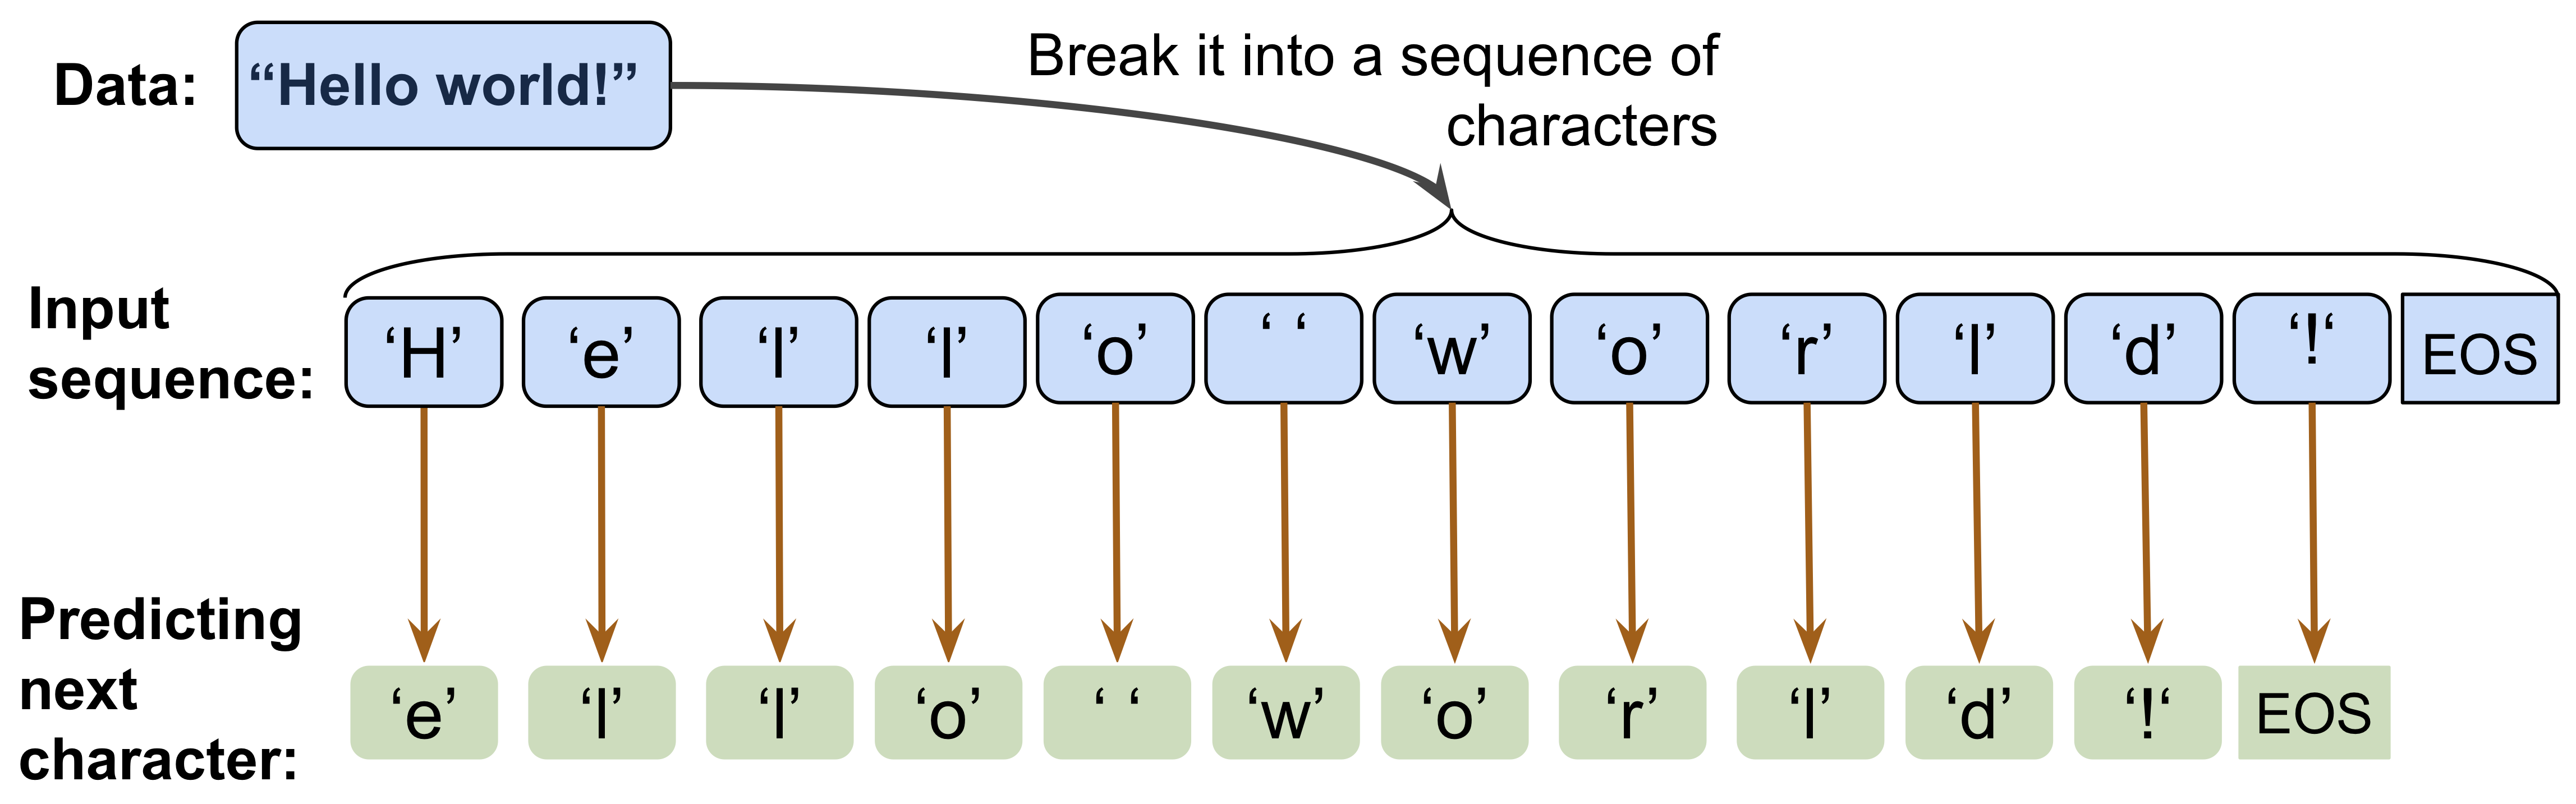

In [3]:
Image(filename='figures/15_11.png', width=700)

### Preprocessing the dataset

In [4]:
import numpy as np

## Reading and processing text
with open('1268-0.txt', 'r', encoding="utf8") as fp:
    text=fp.read()
    
start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')

text = text[start_indx:end_indx]
char_set = set(text)
print('Total Length:', len(text))
print('Unique Characters:', len(char_set))

Total Length: 1112350
Unique Characters: 80


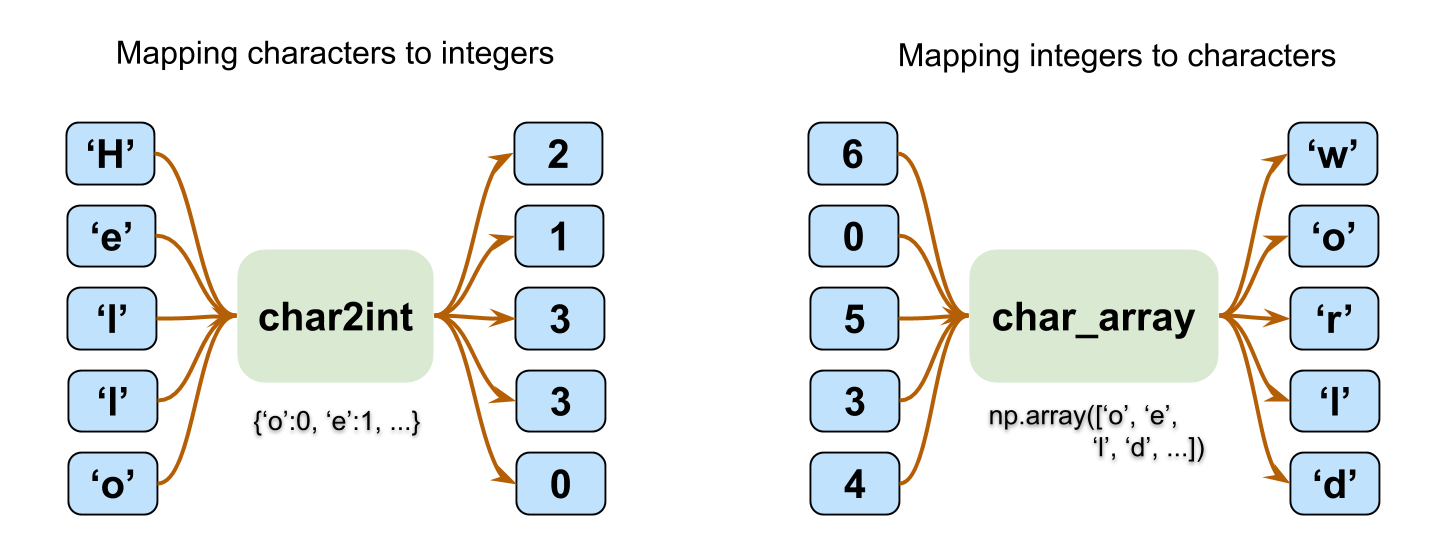

In [5]:
Image(filename='figures/15_12.png', width=700)

In [6]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)

print('Text encoded shape: ', text_encoded.shape)

print(text[:15], '     == Encoding ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == Reverse  ==> ', ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (1112350,)
THE MYSTERIOUS       == Encoding ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == Reverse  ==>  ISLAND


In [7]:
for ex in text_encoded[:5]:
    print('{} -> {}'.format(ex, char_array[ex]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


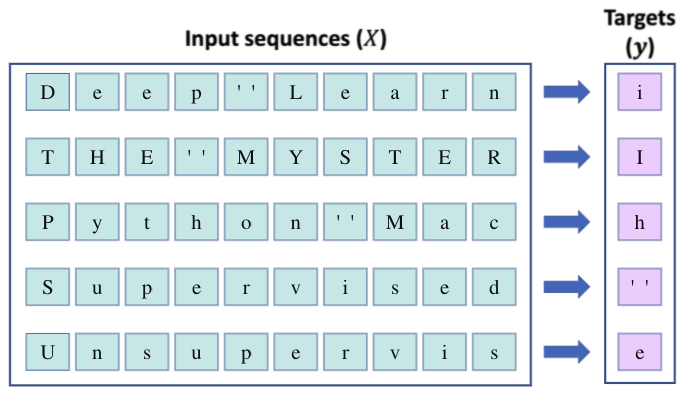

In [8]:
Image(filename='figures/15_13.png', width=700)

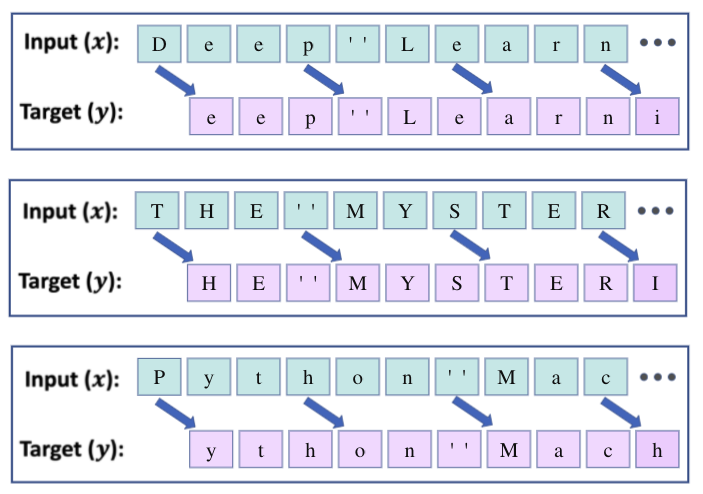

In [9]:
Image(filename='figures/15_14.png', width=700)

In [10]:
seq_length = 40
chunk_size = seq_length + 1

text_chunks = [text_encoded[i:i+chunk_size] 
               for i in range(len(text_encoded)-chunk_size)] 

## inspection:
for seq in text_chunks[:1]:
    input_seq = seq[:seq_length]
    target = seq[seq_length] 
    print(input_seq, ' -> ', target)
    print(repr(''.join(char_array[input_seq])), 
          ' -> ', repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


In [11]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)
    
    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()
    
seq_dataset = TextDataset(torch.tensor(text_chunks))

In [12]:
for i, (seq, target) in enumerate(seq_dataset):
    print(' Input (x):', repr(''.join(char_array[seq])))
    print('Target (y):', repr(''.join(char_array[target])))
    print()
    if i == 1:
        break
    

 Input (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
Target (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

 Input (x): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'
Target (y): 'E MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by '



In [13]:
device = torch.device("cuda:0")
# device = 'cpu'

In [14]:
from torch.utils.data import DataLoader
 
batch_size = 64

torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


### Building a character-level RNN model

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) 
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(device), cell.to(device)
    
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size) 
model = model.to(device)
model

RNN(
  (embedding): Embedding(80, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=80, bias=True)
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000 

torch.manual_seed(1)

for epoch in range(num_epochs):
    hidden, cell = model.init_hidden(batch_size)
    seq_batch, target_batch = next(iter(seq_dl))
    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)
    optimizer.zero_grad()
    loss = 0
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell) 
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()
    optimizer.step()
    loss = loss.item()/seq_length
    if epoch % 500 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')
 

Epoch 0 loss: 4.3719
Epoch 500 loss: 3.0626
Epoch 1000 loss: 3.0635
Epoch 1500 loss: 3.1011
Epoch 2000 loss: 3.0409
Epoch 2500 loss: 3.0556
Epoch 3000 loss: 3.0772
Epoch 3500 loss: 3.1016
Epoch 4000 loss: 3.0059
Epoch 4500 loss: 3.0568
Epoch 5000 loss: 3.0857
Epoch 5500 loss: 3.0614
Epoch 6000 loss: 3.0814
Epoch 6500 loss: 3.0733
Epoch 7000 loss: 3.0303
Epoch 7500 loss: 3.0621
Epoch 8000 loss: 3.0873
Epoch 8500 loss: 3.0368
Epoch 9000 loss: 3.0449
Epoch 9500 loss: 3.0564


### Evaluation phase: generating new text passages

In [17]:
from torch.distributions.categorical import Categorical

torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 1.0]])

print('Probabilities:', nn.functional.softmax(logits, dim=1).numpy()[0])

m = Categorical(logits=logits)
samples = m.sample((10,))
 
print(samples.numpy())

Probabilities: [0.33333334 0.33333334 0.33333334]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [2]
 [1]
 [1]]


In [18]:
torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 3.0]])

print('Probabilities:', nn.functional.softmax(logits, dim=1).numpy()[0])

m = Categorical(logits=logits)
samples = m.sample((10,))
 
print(samples.numpy())

Probabilities: [0.10650698 0.10650698 0.78698605]
[[0]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]]


In [19]:
def sample(model, starting_str, 
           len_generated_text=500, 
           scale_factor=1.0):

    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.eval()
    hidden, cell = model.init_hidden(1)
    hidden = hidden.to('cpu')
    cell = cell.to('cpu')
    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell) 
    
    last_char = encoded_input[:, -1]
    for i in range(len_generated_text):
        logits, hidden, cell = model(last_char.view(1), hidden, cell) 
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])
        
    return generated_str

torch.manual_seed(1)
model.to('cpu')
print(sample(model, starting_str='The island'))

The island aa i fojhhdoe  n.hot”tts  yseeeptw vceb,aeeeardebnaesobrht iy achegha iaienhans
auisro’oa”iehte tttweennnegvhvsv  ,ue.honwadh,fcrmoy,n vdh ,eoha a.boeyfdreamlcGanp  e r
wndhdekisunena   lh
a ee.niw kw  tocmfsioraonl eurs as
dws
asth  yre flmesneeiobseacff
bts semesreida
o d nt ia aessrsefur
rsoy suottdn ttfhlui ,  ewTnwisf nf n  pmaobowos.gWTtrrlreitgv eo gttt arhe egoh an l d
 
leuetke huhe,costth.sdihwtra“f .dc i ohin, tvnohr rt rttcoa , a g  at eeoayo,nanah y t ao” se rt masier  .sereneeo,io


* **Predictability vs. randomness**

In [20]:
logits = torch.tensor([[1.0, 1.0, 3.0]])

print('Probabilities before scaling:        ', nn.functional.softmax(logits, dim=1).numpy()[0])

print('Probabilities after scaling with 0.5:', nn.functional.softmax(0.5*logits, dim=1).numpy()[0])

print('Probabilities after scaling with 0.1:', nn.functional.softmax(0.1*logits, dim=1).numpy()[0])


Probabilities before scaling:         [0.10650698 0.10650698 0.78698605]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611686]
Probabilities after scaling with 0.1: [0.3104238  0.3104238  0.37915248]


In [21]:
torch.manual_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=2.0))

The island    e dieee l.  e eit“ssr  uoaaantt t d    ba o   h arn oes eu   ebee  e eahe hr  teoonvm “eaera ssttaaiheaetetrt   t  eiht  e e nflu i t e  die     latd n  ee   hn  a n
th e ceerthcg    ee
  aa het et  tl edoein lee btnr  r  tr  rte  toc eeebrhcael oa  de  rr paebroae  
i   hs e   arrnodetn opiu othtr h tsceete    at hteoe he h  ne n ntio e  sooeoceret al etss  ne   eie  h e     e t sea ete   ioste o eetro wd     e meeg  tthlen ns oss l      e   s aan ui h e e v t  iy r  os e reao   r oahadi em


In [22]:
torch.manual_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=0.5))

The island ILAi,fokghbod ,mDhow”uut1;“seeerwy?yafaBOceeasbcanSetpashu,j“.NaheghU;iNhemhJnt
Ywisrp”pM”ieite,uuvzeeonmegyhyty ;BwcFhon‘MbhAgarmp”Bo.ybh,?fohO0PFaoe“fcrcOllaGSnr, e r
ynahcekitwnemT-.0lh
L eeGoi‘7ky
7wpamfsiorToml ewrt at
byt
Otvh2 ’se;flmetneeipaseMaff
att seletrdicM
o0c.nu?iN Rdttrsffwr
rso“ sxowtbn;vufhlwj,A..d‘InzitfAnf-n -rmapaqyosFgKHtsrlsejtfy:eo gvuu,Trhc,cgog Tn l b
 
lcwcule iwhcBaostwhEsbjgytsW”f Fca,i phinA,vynphr ru!svuaoJ,A T.g, Wt!edoM“oBnImag ” w To”;td:su7mMtker,.CtcseneeoBkp


# Understanding language with the Transformer model

## Understanding the self-attention mechanism

## A basic version of self-attention



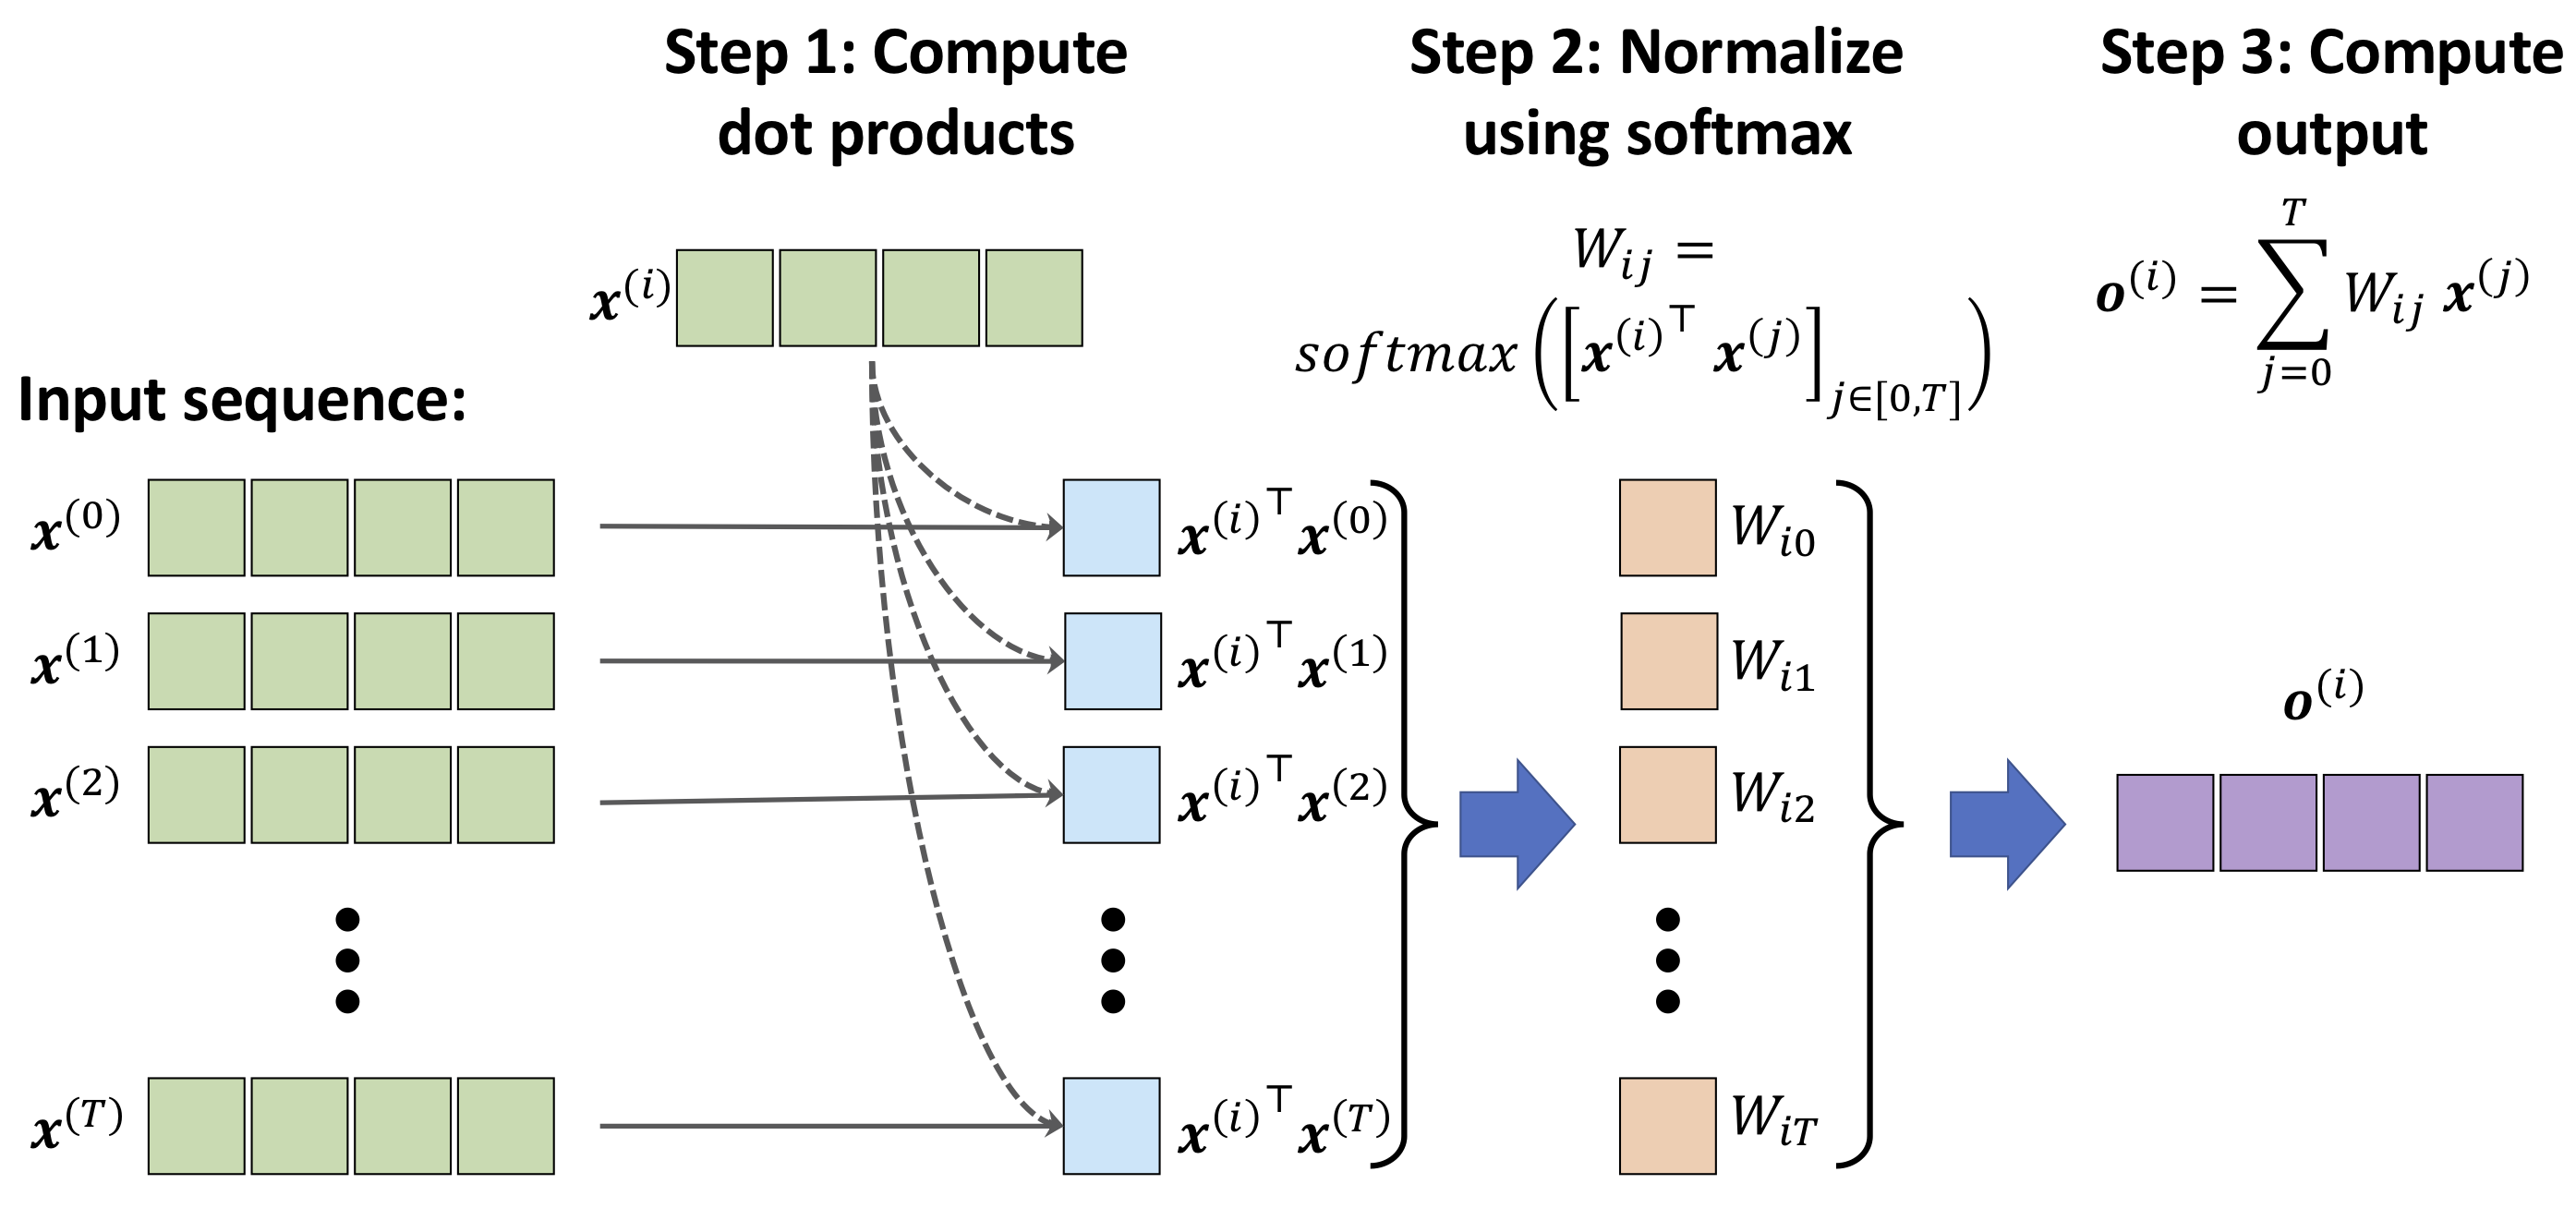

In [23]:
Image(filename='figures/15_15.png', width=700)

### Parameterizing the self-attention mechanism with query, key, and value weights



## Multi-head attention and the Transformer block

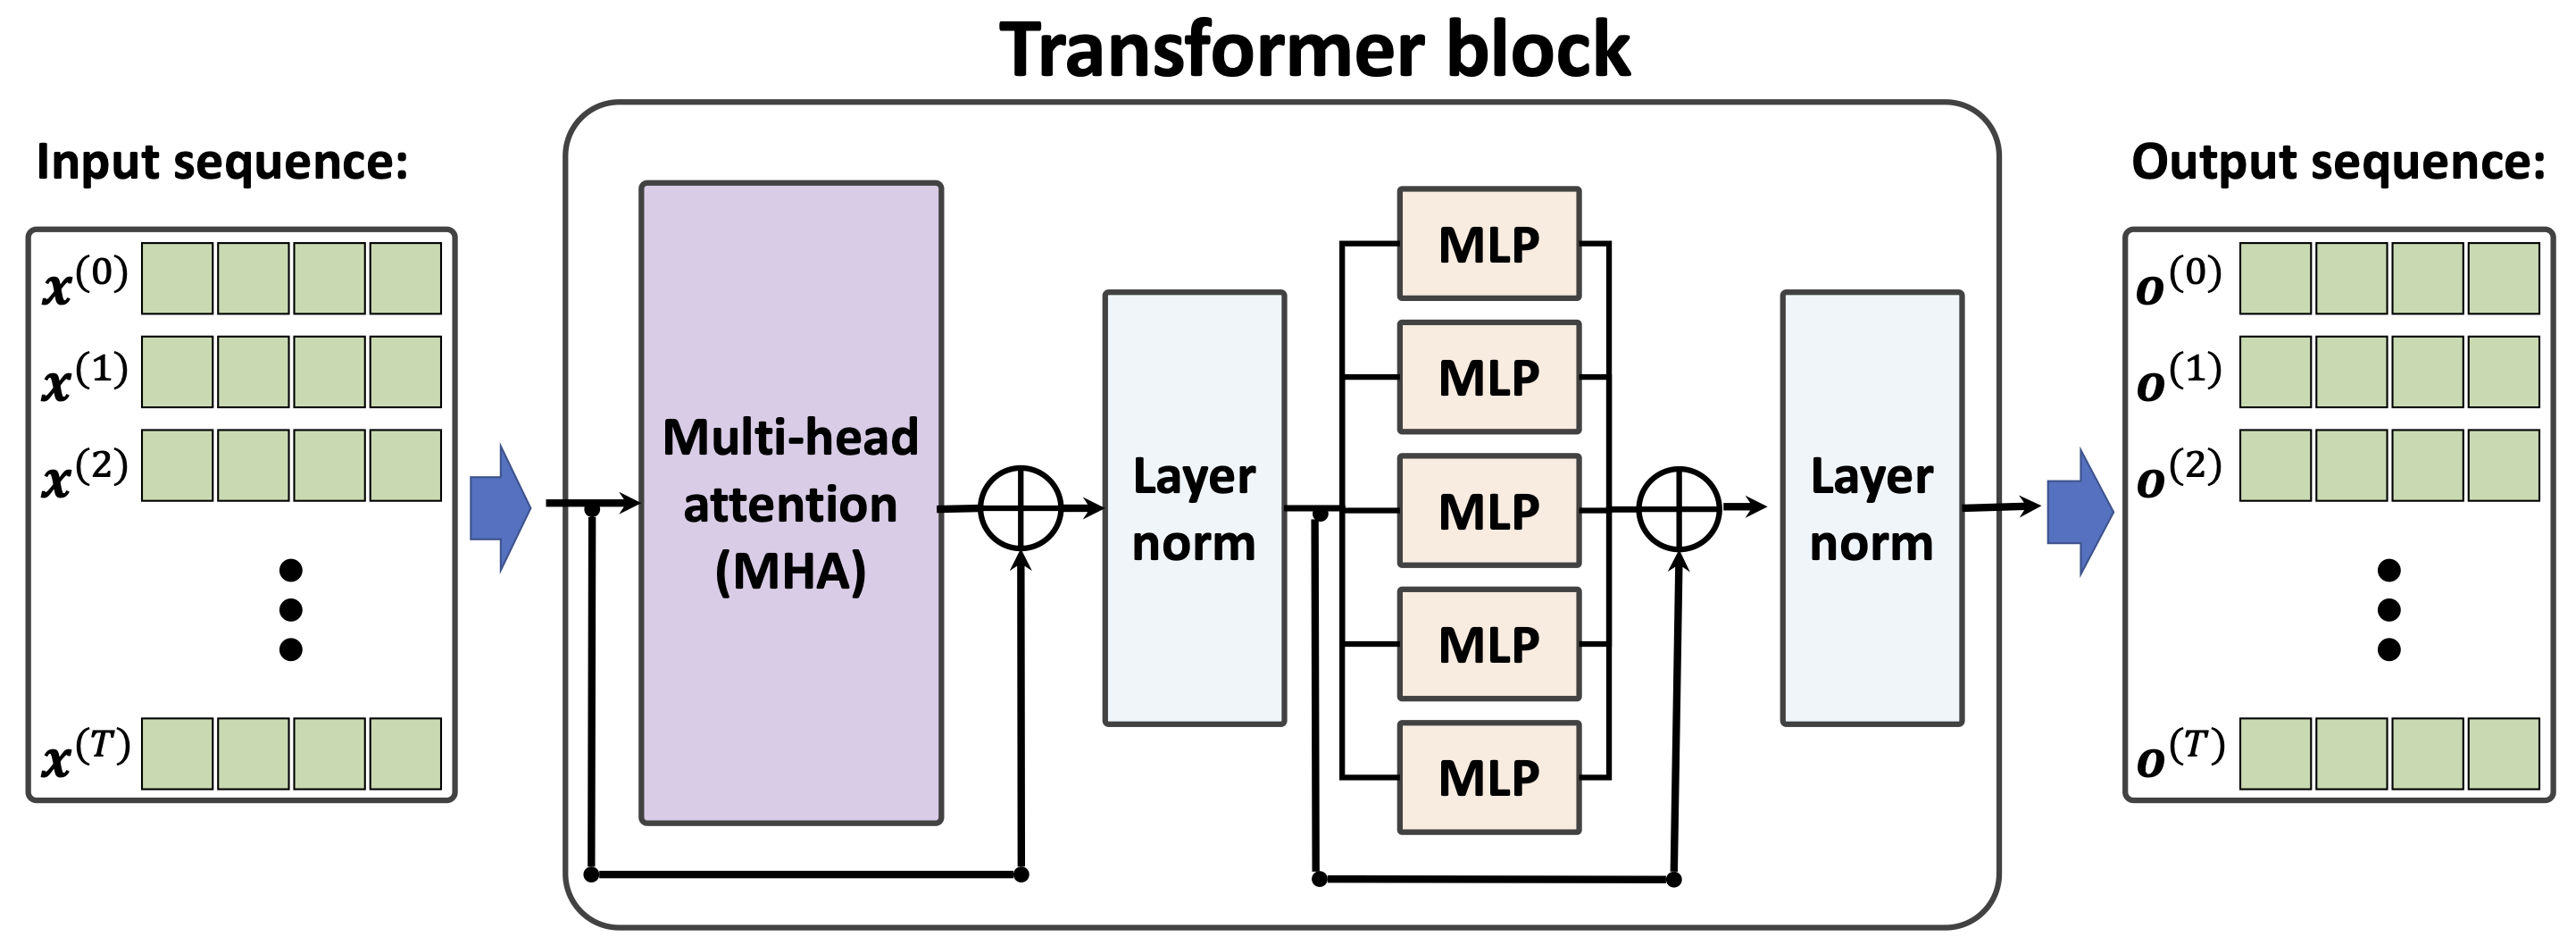

In [24]:
Image(filename='figures/15_16.png', width=700)


...


# Summary

...




Readers may ignore the next cell.


In [3]:
! python ../.convert_notebook_to_script.py --input ch15_part3.ipynb --output ch15_part3.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch15_part3.ipynb to script
[NbConvertApp] Writing 8360 bytes to ch15_part3.py
